## **Import Libaries**

In [1]:
!pip install opencv-python-headless

import os
import random
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas
from collections import Counter
import kagglehub


# **Image Categories**

In [3]:
image_path = '/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals'
Categories = []
for c in os.listdir(image_path):
    Categories.append(c)
print(Categories)

['dogs', 'panda', 'cats']


In [4]:
train_data = []
IMG_SIZE = 32
for c in Categories:
    path = os.path.join(image_path,c)
    class_num = Categories.index(c)
    for img in tqdm(os.listdir(path)):
      try:
          img_arr = cv2.imread(os.path.join(path,img))
          img_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
          train_data.append([img_arr, class_num])
      except WException as e:
            pass

print(len(train_data))

100%|██████████| 1000/1000 [00:12<00:00, 78.64it/s]

3000


# **Display Randomly Selected Photo & Converting It to grey-scale**

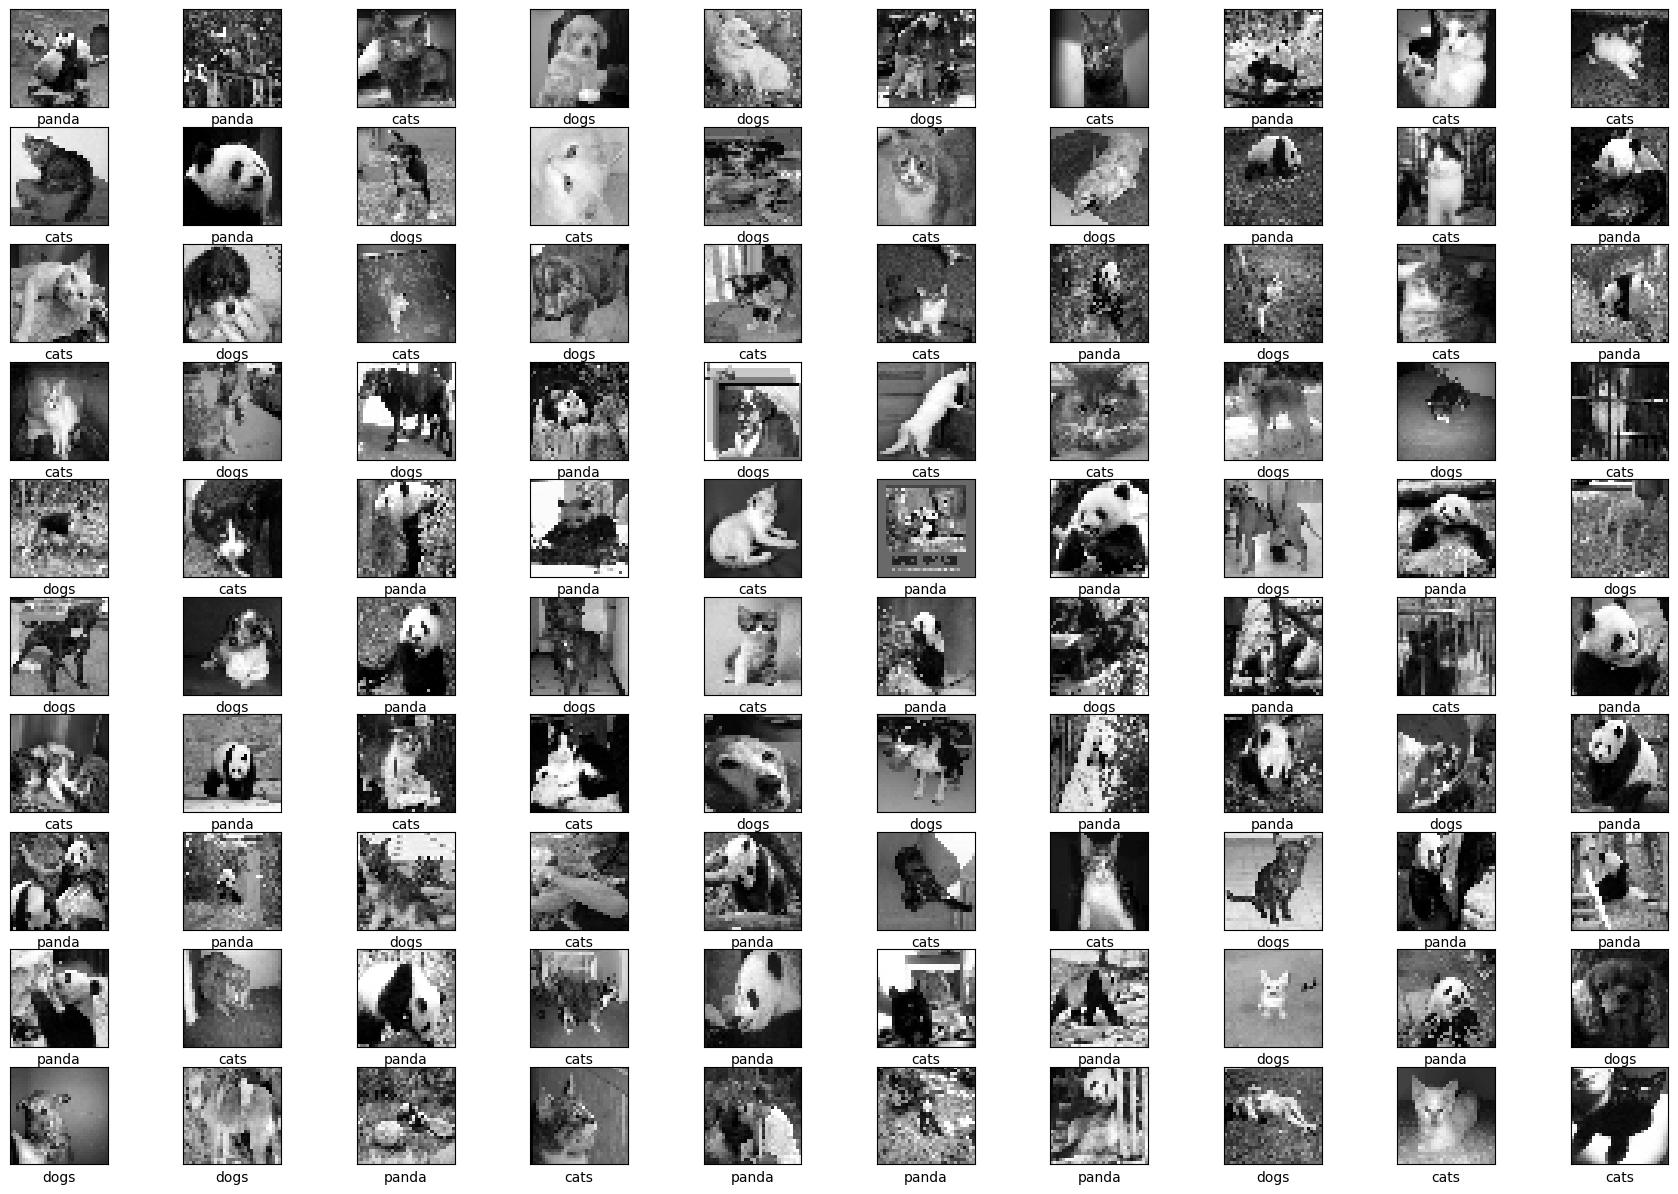

In [5]:
random.shuffle(train_data)
plt.figure(figsize=(22,15))
for i in range(100):
    plt.subplot(10,10,i+1)
    image = train_data[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(Categories[train_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i==100:
        break
plt.show()

# **Training**

In [6]:
f0 = train_data[0:600]
f1 = train_data[600:1200]
f2 = train_data[1200:1800]
f3 = train_data[1800:2400]
f4 = train_data[2400:3000]

In [7]:
def l1_dist(image1, image2):
    return np.sum(np.abs(image1 - image2))

def l2_dist(image1, image2):
    return np.sqrt(np.sum((image1 - image2) ** 2))


In [8]:
def by_l1_dist(list):
    return list[2]["l1"]

def by_l2_dist(list):
    return list[2]["l2"]


In [9]:
top_filter = 20

def distance_calc(train_fold, valid_fold):
    l1_result = []
    l2_result = []

    for valid in tqdm(valid_fold):
        temp_dist_list = []

        for train in train_fold:
            l1_distance = l1_dist(valid[0], train[0])
            l2_distance = l2_dist(valid[0], train[0])
            temp_dist_list.append([valid[1],  train[1], {"l1": l1_distance, "l2": l2_distance}])

        temp_dist_list.sort(key=by_l1_dist)
        l1_result.append(temp_dist_list[:top_filter])
        temp_dist_list.sort(key=by_l2_dist)
        l2_result.append(temp_dist_list[:top_filter])

    return [l1_result, l2_result]


In [10]:
k_range = 20

def cal_accuracy(dist_result, dist_term):
    k_accuracies = []

    for k in range(1, k_range+1):
        img_accuracy = 0
        for valid_img in dist_result:
            nn = valid_img[:k]
            same_class = [n for n in nn if n[0] == n[1]]
            same_class_len = len(same_class)

            if k % 2 != 0:
                if ((k-1) / 2) < same_class_len:
                    img_accuracy += 1

            else:
                diff_class = [n for n in nn if n[0] != n[1]]
                if same_class_len > len(diff_class):
                    img_accuracy += 1
                elif same_class_len == len(diff_class): # in case of a tie
                    same_class_dist = sum([n[2][dist_term] for n in same_class])
                    diff_class_dist = sum([n[2][dist_term] for n in diff_class])
                    if same_class_dist > diff_class_dist:
                        img_accuracy += 1

        k_accuracies.append(img_accuracy/len(dist_result))


    return k_accuracies




In [11]:
dist_by_fold = []
import math
for i in range(5):
    if i==0:
        train = f1+f2+f3+f4
        validation = f0
    elif i==1:
        train = f0+f2+f3+f4
        validation = f1
    elif i==2:
        train = f1+f0+f3+f4
        validation = f2
    elif i==3:
        train = f1+f2+f0+f4
        validation = f3
    elif i==4:
        train = f1+f2+f3+f0
        validation = f4

    dist_by_fold.append(distance_calc(train, validation))


100%|██████████| 600/600 [00:33<00:00, 17.74it/s]


In [12]:
len(dist_by_fold[0][0])

600

In [13]:
accuracies = []

for result in dist_by_fold:
    l1_accuracy = cal_accuracy(result[0], "l1")
    l2_accuracy = cal_accuracy(result[1], "l2")
    accuracies.append([l1_accuracy, l2_accuracy])



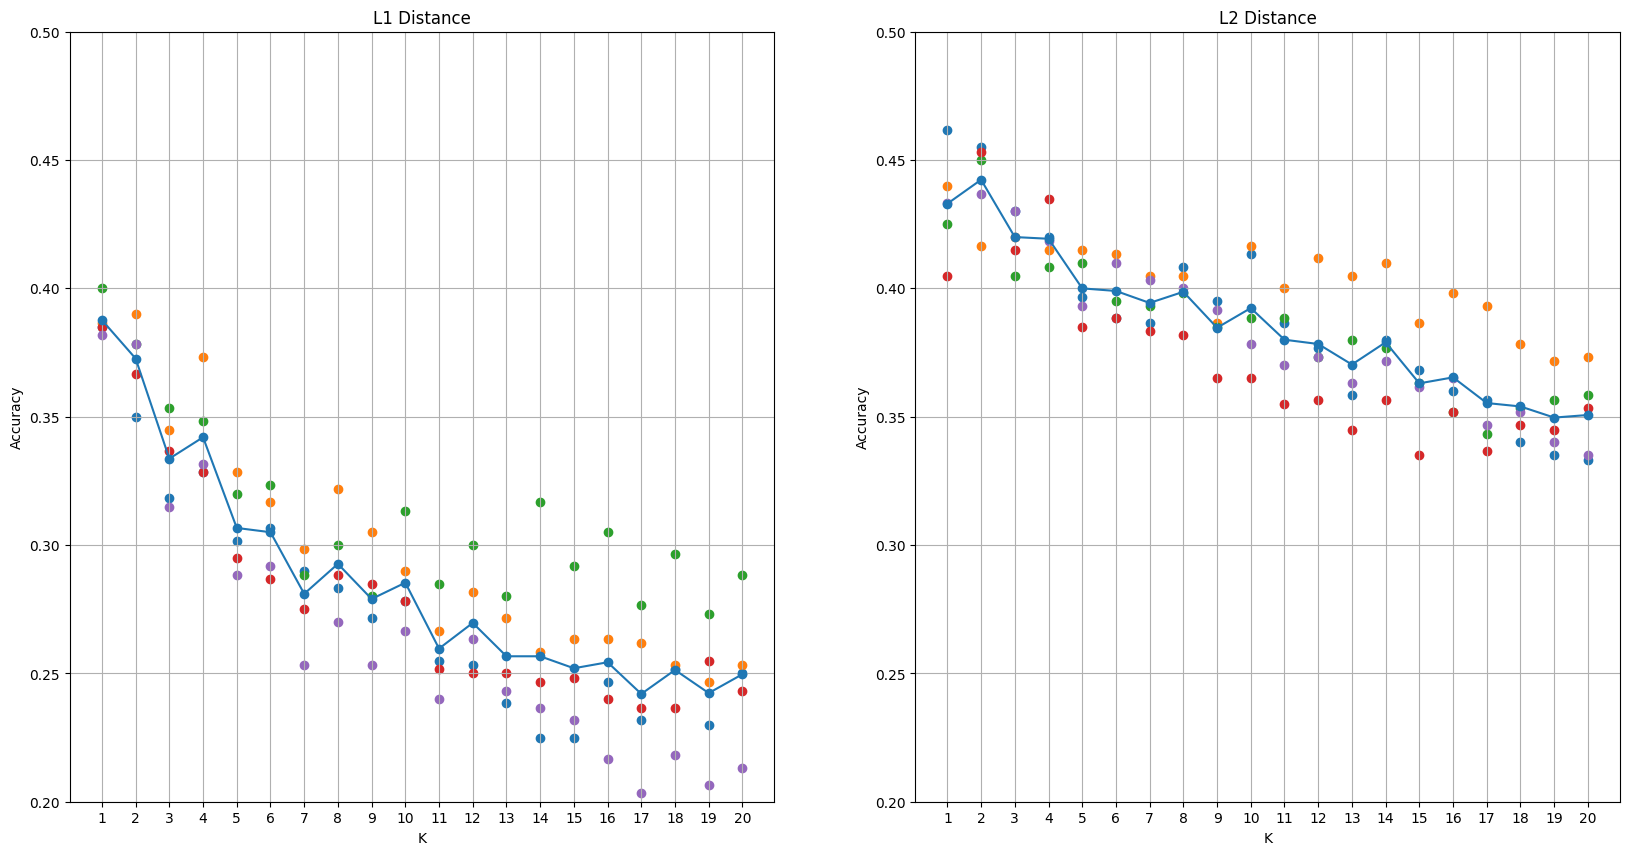

In [14]:
x_list = list(range(1, k_range+1))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)

for fold in accuracies:
  y_list = fold[0]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[0][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L1 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)

x_list = list(range(1, k_range+1))

plt.subplot(1,2,2)
for fold in accuracies:
  y_list = fold[1]
  plt.scatter(x_list, y_list)

arr = []
for i in range(k_range):
  arr.append([fold[1][i] for fold in accuracies])

trend = [np.mean(a) for a in arr]

plt.errorbar(x_list, trend,fmt='-o')
plt.title('L2 Distance')
plt.xticks(x_list)
plt.grid(True)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.ylim(0.2, 0.5)
plt.show()

# **Discussion**

The visualization presents a comparative evaluation of L1 (Manhattan) and L2 (Euclidean) distance metrics across five cross-validation folds using a K-nearest neighbors (KNN) classifier on an animal image classification task. The left plot illustrates the performance trends for the L1 metric, while the right plot shows results for the L2 metric. Both graphs display classification accuracy across K values ranging from 1 to 20, with each colored point denoting a specific fold’s performance at a given K. The blue line represents the mean accuracy across all folds, effectively highlighting overall trends. This visualization approach enables a nuanced understanding of how neighborhood size and distance metric influence classifier accuracy, revealing distinct behavioral patterns between L1 and L2.


---


**Accuracy:**
The accuracy trends indicate a notable difference in performance between the two distance metrics. For L1 distance, accuracy peaks around 0.43–0.44 at K=1 but declines sharply beyond K=5, dropping below 0.25 as K exceeds 15. This steep degradation suggests that Manhattan distance becomes less effective as the neighborhood size increases, possibly due to its sensitivity to high-dimensional noise. Conversely, the L2 metric consistently outperforms L1, reaching a maximum accuracy of approximately 0.48–0.49 at K=2 and maintaining relatively stable performance above 0.35 across a broader range of K values. This suggests that Euclidean distance more effectively captures the structure of the image data. While both metrics exhibit consistent performance across the five folds, L2 demonstrates slightly higher variability in the mid-K range (K=3 to K=15). Overall, the results support the selection of L2 distance with a small K (preferably K=2) as the optimal configuration for this dataset.


---


**Limitations:**
Despite offering valuable insights, the analysis has several limitations. First, even under optimal conditions, the accuracy remains below 0.50, highlighting the limited effectiveness of basic KNN models for complex image classification tasks. Second, the dataset size—consisting of only 3,000 images (600 per fold)—may not adequately capture the variability in animal appearances, potentially limiting the model's generalizability. Third, the low resolution of 32x32 pixels likely restricts the amount of discriminative visual information available, which may hinder performance. Additionally, the study does not explore enhancements such as image preprocessing, advanced feature extraction, or weighted voting schemes that could improve classification outcomes. Evaluation is solely based on accuracy, overlooking other critical metrics like precision, recall, or F1-score, which are essential for understanding class-specific performance, especially in the case of dataset imbalance. Finally, the analysis is limited to only two distance metrics, excluding alternative measures such as cosine similarity or Mahalanobis distance, which might offer improved classification for image-based data.

Top 5 Predictions for L1 Distance:
Prediction 1: Class 'dogs' with L1 distance 0.00
Prediction 2: Class 'cats' with L1 distance 882.54
Prediction 3: Class 'cats' with L1 distance 888.02
Prediction 4: Class 'cats' with L1 distance 900.47
Prediction 5: Class 'dogs' with L1 distance 903.11

Top 5 Predictions for L2 Distance:
Prediction 1: Class 'dogs' with L2 distance 0.00
Prediction 2: Class 'cats' with L2 distance 298.75
Prediction 3: Class 'dogs' with L2 distance 301.38
Prediction 4: Class 'cats' with L2 distance 302.92
Prediction 5: Class 'cats' with L2 distance 304.46


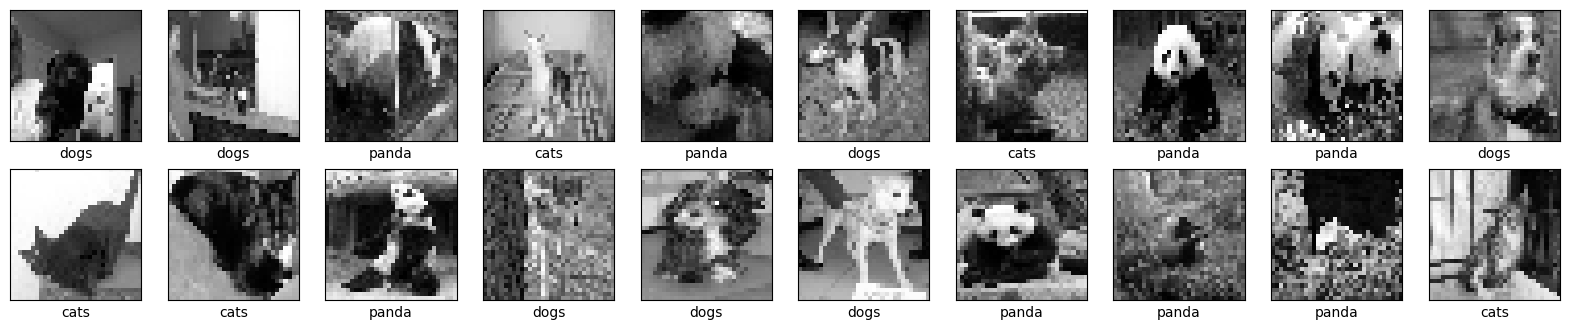

In [15]:
random.shuffle(train_data)

plt.figure(figsize=(20, 10))

for i in range(20):
    plt.subplot(5, 10, i+1)
    image = train_data[i][0]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(image_gray, cmap="gray")
    plt.xlabel(Categories[train_data[i][1]])
    plt.xticks([])
    plt.yticks([])
    if i == 19:
        break

test_images = []

for i in range(3000):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append(test_image_gray)

print("Top 5 Predictions for L1 Distance:")
for test_image_gray in test_images:
    distances1 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist1 = l1_dist(test_image_gray, train_image_gray)
        distances1.append((dist1, class_num))
    distances1.sort(key=lambda x: x[0])

    for i, (dist1, class_num) in enumerate(distances1[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L1 distance {dist1/100:.2f}")
    break

print("\nTop 5 Predictions for L2 Distance:")
for test_image_gray in test_images:
    distances2 = []
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray, train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    for i, (dist2, class_num) in enumerate(distances2[:5]):
        predicted_class = Categories[class_num]
        print(f"Prediction {i+1}: Class '{predicted_class}' with L2 distance {dist2:.2f}")
    break

Classes with their number of occurances: {'dogs': [2, 308.28720375649715], 'cats': [1, 306.75560304581234]}
max number of at common class: 2
highest probable class: ['dogs']


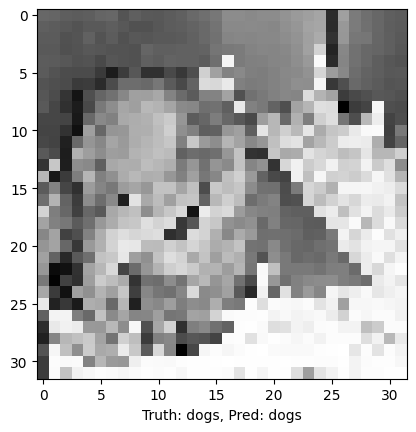



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 607.5722063727893]}
max number of at common class: 2
highest probable class: ['cats']


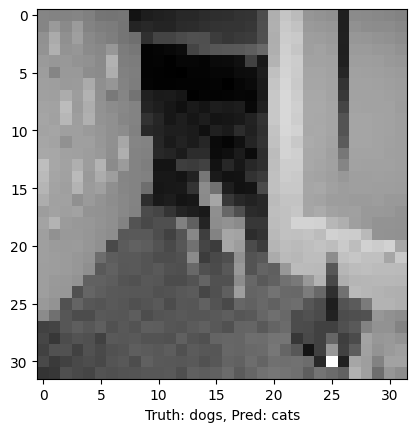



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 578.1398008691681]}
max number of at common class: 2
highest probable class: ['cats']


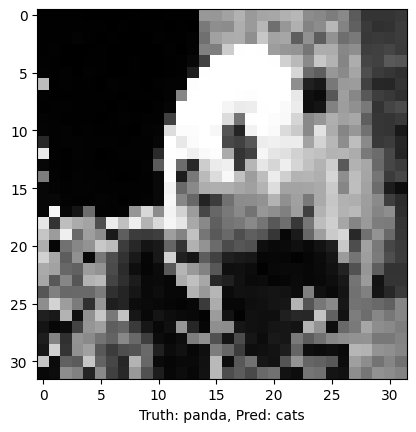



Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [2, 627.5553508904922]}
max number of at common class: 2
highest probable class: ['dogs']


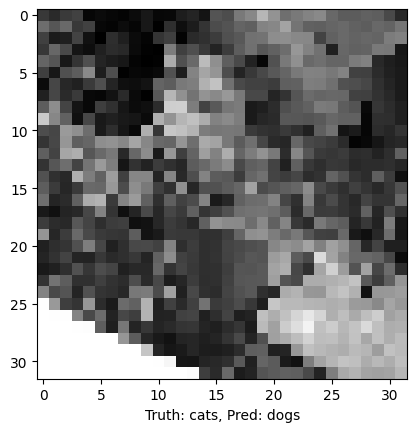



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [1, 314.0955268704093], 'dogs': [1, 314.47098435308783]}
max number of at common class: 1
highest probable class: ['panda', 'cats', 'dogs']
Class with the least error: (['panda'], 0.0)


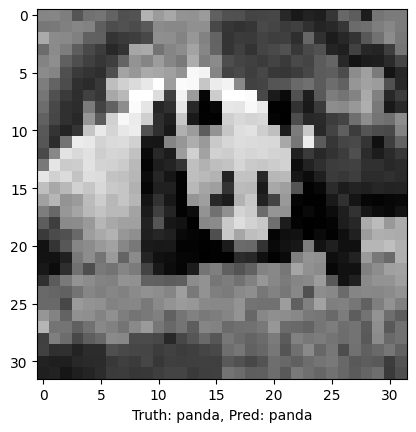



Classes with their number of occurances: {'dogs': [3, 613.900556116123]}
max number of at common class: 3
highest probable class: ['dogs']


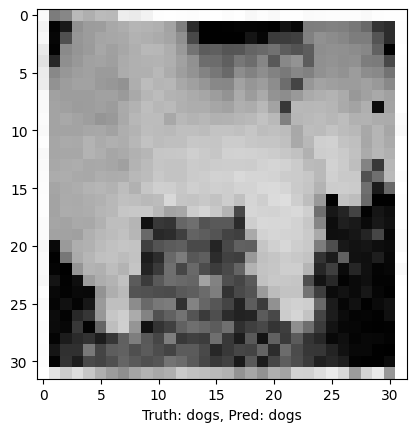



Classes with their number of occurances: {'dogs': [2, 311.4225425366635], 'cats': [1, 313.410274241289]}
max number of at common class: 2
highest probable class: ['dogs']


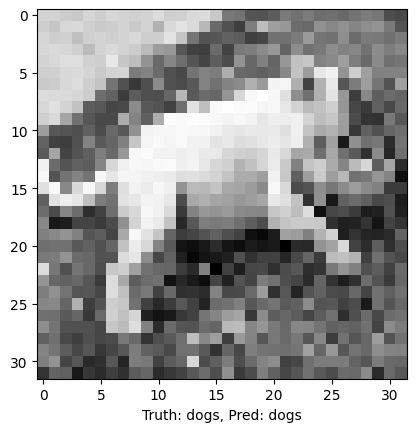



Classes with their number of occurances: {'dogs': [1, 0.0], 'panda': [2, 630.4347706067106]}
max number of at common class: 2
highest probable class: ['panda']


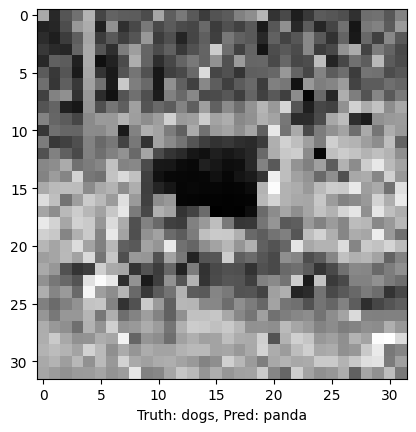



Classes with their number of occurances: {'panda': [3, 618.009606136633]}
max number of at common class: 3
highest probable class: ['panda']


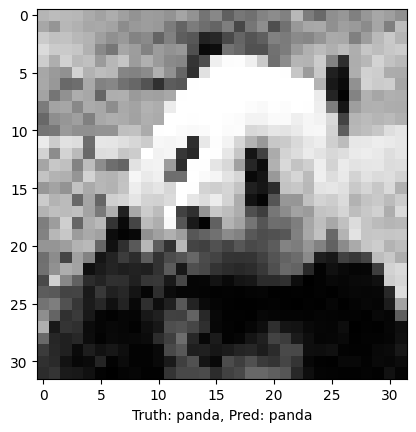



Classes with their number of occurances: {'dogs': [2, 303.1385821699376], 'cats': [1, 307.1156134096735]}
max number of at common class: 2
highest probable class: ['dogs']


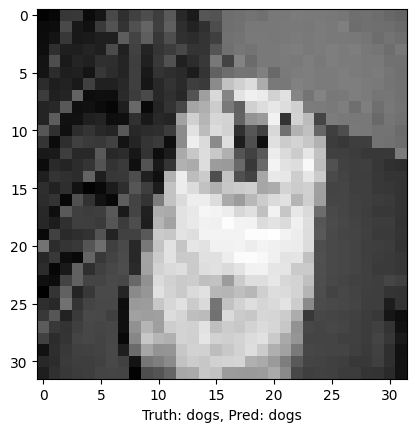



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 630.5169224112817]}
max number of at common class: 2
highest probable class: ['cats']


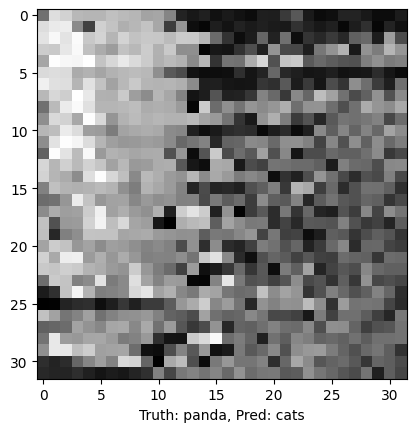



Classes with their number of occurances: {'cats': [3, 617.1166054510026]}
max number of at common class: 3
highest probable class: ['cats']


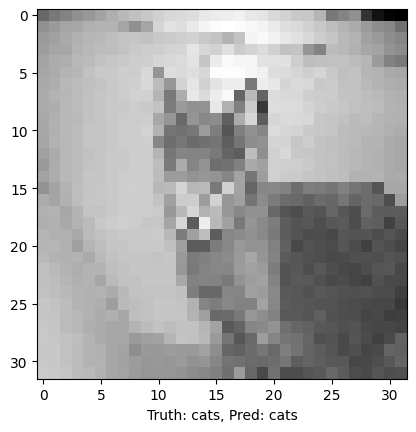



Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [1, 288.52902800238314], 'cats': [1, 295.50634510954245]}
max number of at common class: 1
highest probable class: ['panda', 'dogs', 'cats']
Class with the least error: (['panda'], 0.0)


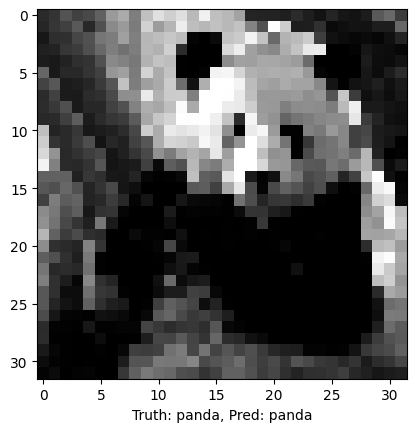



Classes with their number of occurances: {'panda': [1, 0.0], 'dogs': [1, 310.86170558626225], 'cats': [1, 311.5702168051369]}
max number of at common class: 1
highest probable class: ['panda', 'dogs', 'cats']
Class with the least error: (['panda'], 0.0)


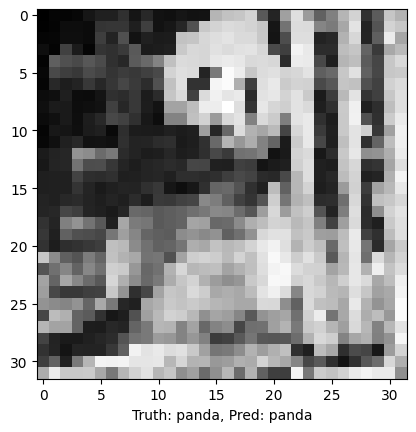



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 599.3286392334055]}
max number of at common class: 2
highest probable class: ['cats']


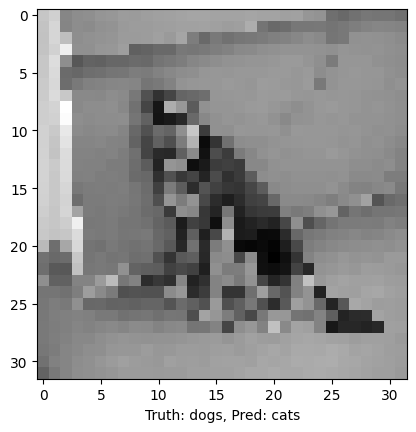



Classes with their number of occurances: {'cats': [2, 305.41938379873665], 'dogs': [1, 305.75480372350654]}
max number of at common class: 2
highest probable class: ['cats']


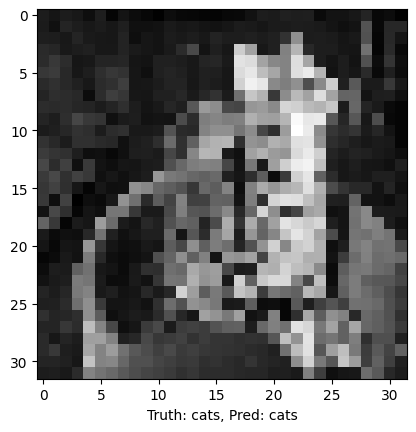



Classes with their number of occurances: {'dogs': [2, 310.8970890825451], 'cats': [1, 312.90573660449246]}
max number of at common class: 2
highest probable class: ['dogs']


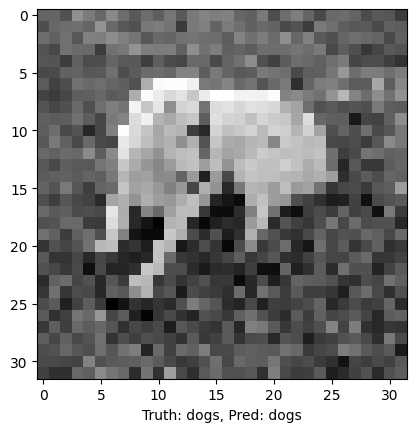



Classes with their number of occurances: {'cats': [3, 603.0907638006026]}
max number of at common class: 3
highest probable class: ['cats']


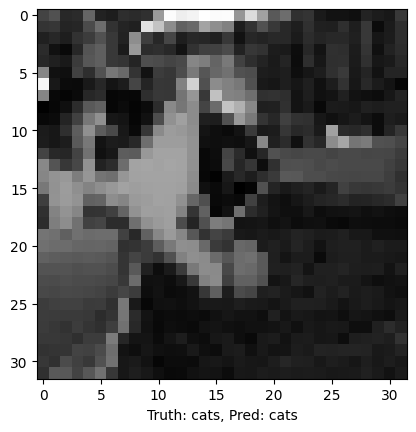



Classes with their number of occurances: {'panda': [2, 314.64742172787624], 'cats': [1, 314.45190411253674]}
max number of at common class: 2
highest probable class: ['panda']


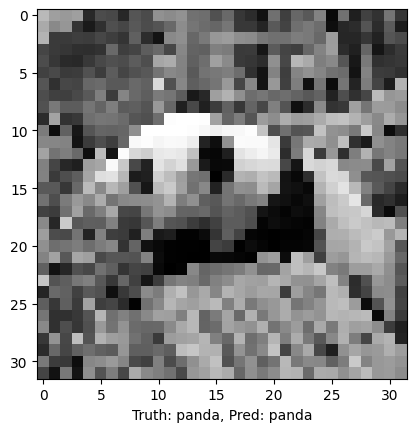



Classes with their number of occurances: {'cats': [2, 310.5382424114621], 'panda': [1, 307.31254448850603]}
max number of at common class: 2
highest probable class: ['cats']


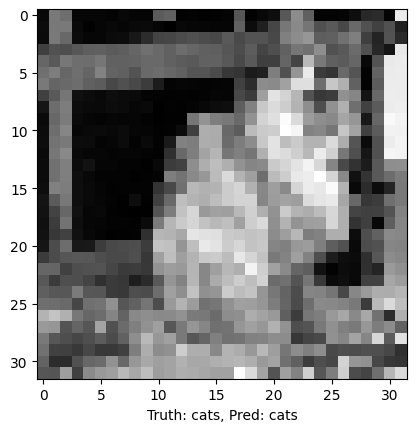



Classes with their number of occurances: {'panda': [3, 627.0215043715934]}
max number of at common class: 3
highest probable class: ['panda']


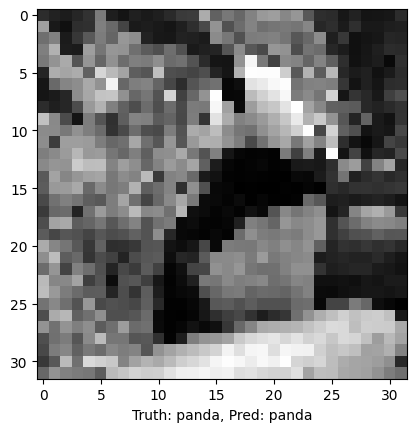



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 619.7737854501358]}
max number of at common class: 2
highest probable class: ['cats']


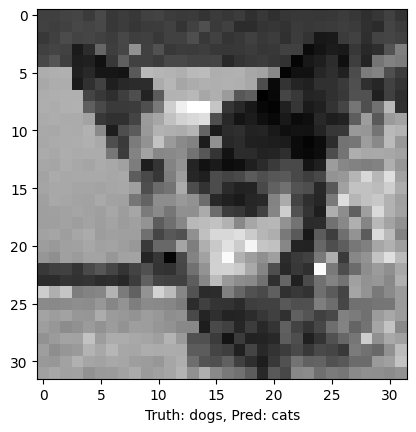



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [1, 307.67352827307064], 'dogs': [1, 309.118100408242]}
max number of at common class: 1
highest probable class: ['panda', 'cats', 'dogs']
Class with the least error: (['panda'], 0.0)


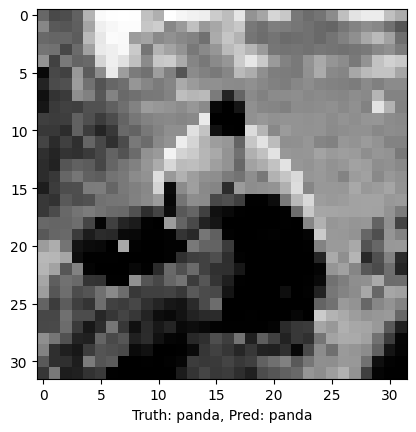



Classes with their number of occurances: {'panda': [2, 309.74828490243493], 'cats': [1, 304.4601780200491]}
max number of at common class: 2
highest probable class: ['panda']


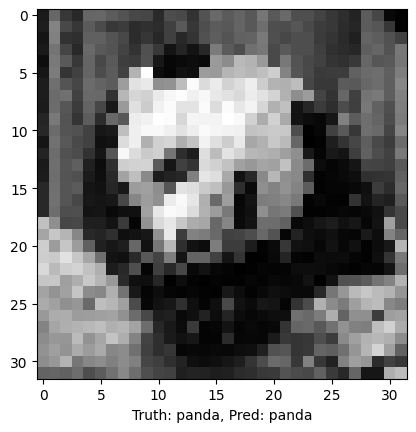



Classes with their number of occurances: {'cats': [2, 312.5555950547038], 'dogs': [1, 312.6371698950718]}
max number of at common class: 2
highest probable class: ['cats']


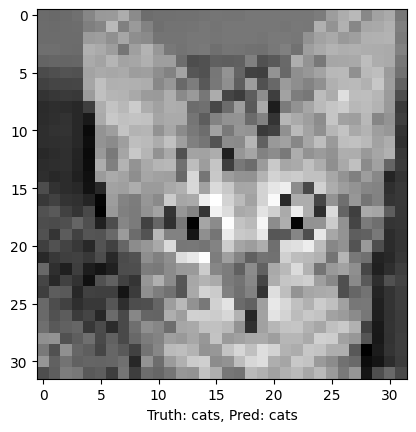



Classes with their number of occurances: {'cats': [1, 0.0], 'panda': [1, 309.8209160143969], 'dogs': [1, 310.795752866734]}
max number of at common class: 1
highest probable class: ['cats', 'panda', 'dogs']
Class with the least error: (['cats'], 0.0)


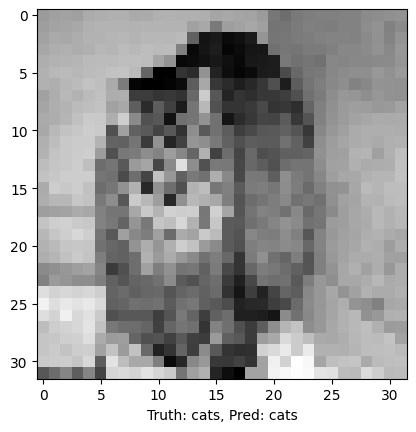



Classes with their number of occurances: {'dogs': [2, 312.5235991089313], 'cats': [1, 311.44823004794875]}
max number of at common class: 2
highest probable class: ['dogs']


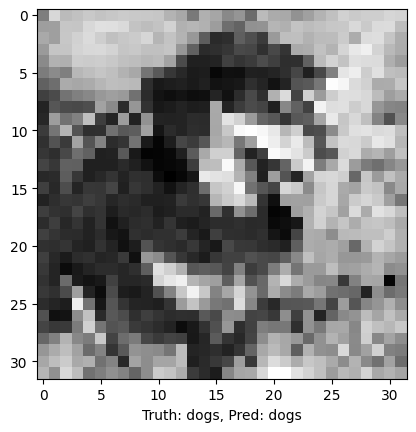



Classes with their number of occurances: {'cats': [2, 312.02403753557195], 'panda': [1, 312.50759990758627]}
max number of at common class: 2
highest probable class: ['cats']


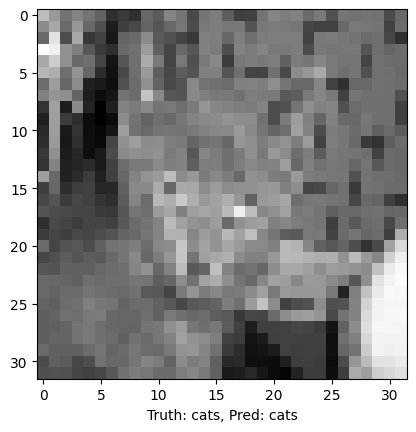



Classes with their number of occurances: {'panda': [3, 622.2117161086956]}
max number of at common class: 3
highest probable class: ['panda']


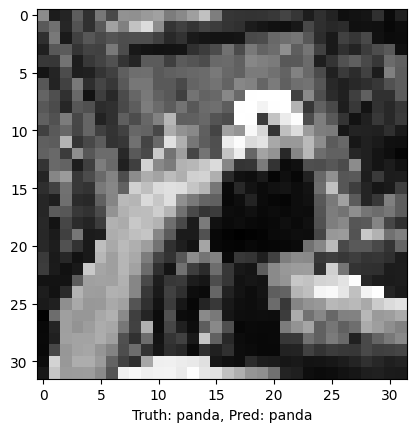



Classes with their number of occurances: {'cats': [1, 0.0], 'dogs': [2, 610.9790483526176]}
max number of at common class: 2
highest probable class: ['dogs']


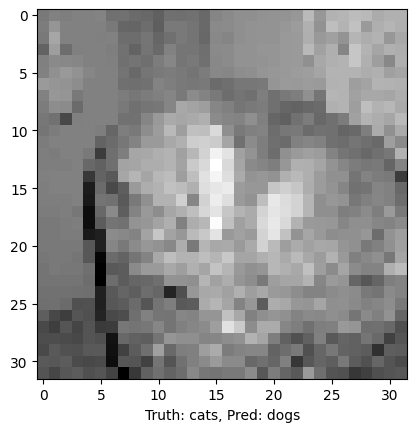



Classes with their number of occurances: {'cats': [1, 0.0], 'panda': [1, 312.5027999874561], 'dogs': [1, 313.1405435263853]}
max number of at common class: 1
highest probable class: ['cats', 'panda', 'dogs']
Class with the least error: (['cats'], 0.0)


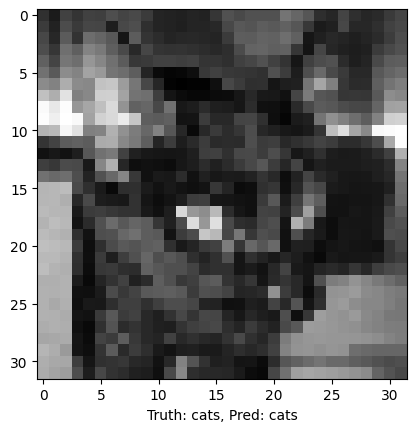



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 623.0148962139031]}
max number of at common class: 2
highest probable class: ['cats']


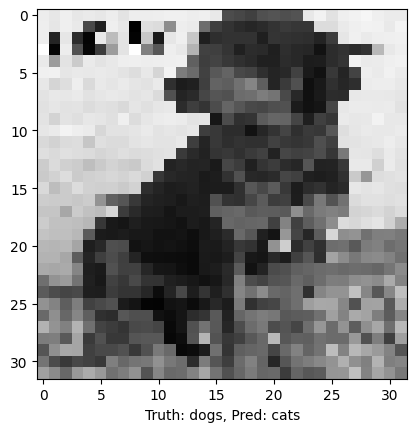



Classes with their number of occurances: {'cats': [3, 565.0852401833663]}
max number of at common class: 3
highest probable class: ['cats']


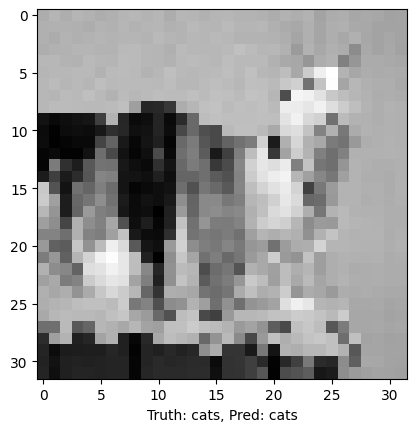



Classes with their number of occurances: {'dogs': [1, 0.0], 'cats': [2, 625.6351550148095]}
max number of at common class: 2
highest probable class: ['cats']


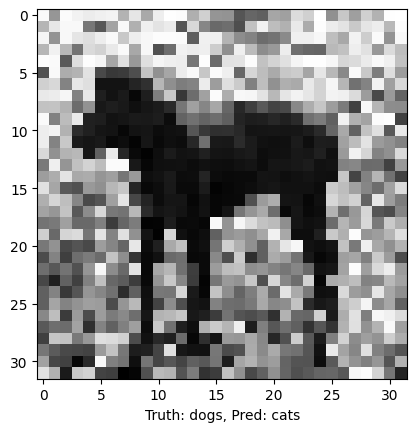



Classes with their number of occurances: {'cats': [2, 293.0204771001508], 'dogs': [1, 293.92856274952254]}
max number of at common class: 2
highest probable class: ['cats']


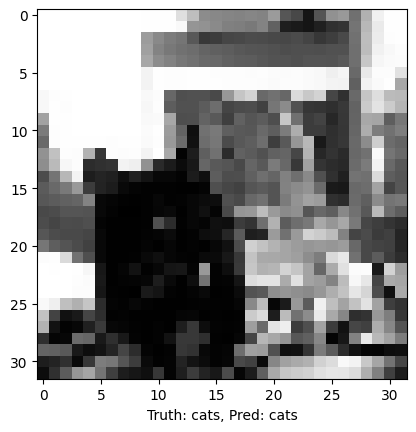



Classes with their number of occurances: {'cats': [3, 619.1511828964585]}
max number of at common class: 3
highest probable class: ['cats']


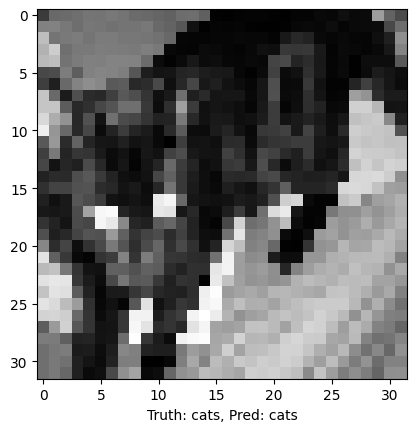



Classes with their number of occurances: {'panda': [2, 304.79337263136154], 'cats': [1, 303.9983552587086]}
max number of at common class: 2
highest probable class: ['panda']


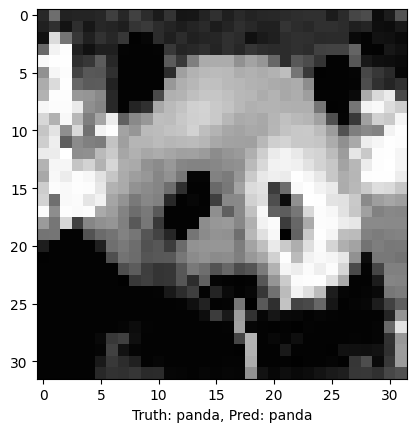



Classes with their number of occurances: {'panda': [1, 0.0], 'cats': [2, 625.213271185495]}
max number of at common class: 2
highest probable class: ['cats']


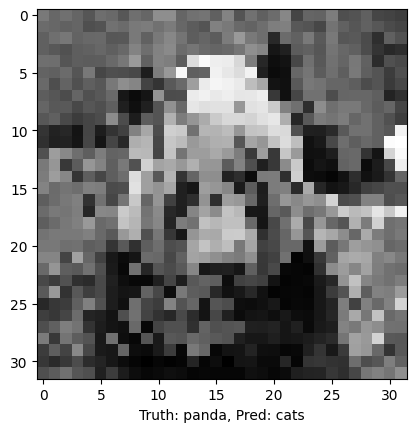



Classes with their number of occurances: {'cats': [2, 312.5859881696555], 'dogs': [1, 312.11215932738025]}
max number of at common class: 2
highest probable class: ['cats']


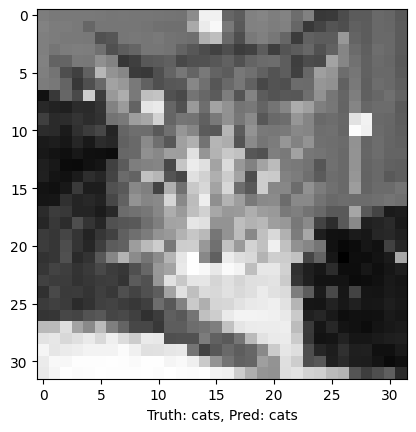



Classes with their number of occurances: {'dogs': [3, 610.2523624330149]}
max number of at common class: 3
highest probable class: ['dogs']


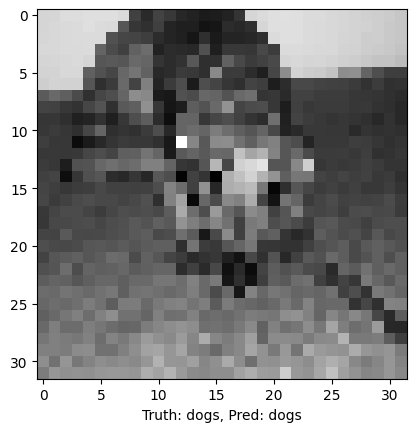



Correctly predicted 29 images out of 40, overall accuracy: 72.5 %


In [16]:
random.shuffle(train_data)

test_images = []
neighbours = 3
test_count = 40

for i in range(test_count):
    test_image = train_data[i][0]
    test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
    test_images.append([test_image_gray, train_data[i][1]])

accurate = 0

for test_image_gray in test_images:
    distances2 = []
    pred = None
    for train_image, class_num in train_data:
        train_image_gray = cv2.cvtColor(train_image, cv2.COLOR_BGR2GRAY)
        dist2 = l2_dist(test_image_gray[0], train_image_gray)
        distances2.append((dist2, class_num))
    distances2.sort(key=lambda x: x[0])

    prediction_classes = [[cl[0], Categories[cl[1]]] for cl in distances2[:neighbours]]
    occurrences_dict = {pc[1]: [0,0] for pc in prediction_classes}
    for pc in prediction_classes:
      if pc[1] in occurrences_dict:
          occurrences_dict[pc[1]][0] = occurrences_dict[pc[1]][0] + 1
          occurrences_dict[pc[1]][1] += pc[0]
      else:
          occurrences_dict[pc[1]][0] = 1
          occurrences_dict[pc[1]][1] += pc[0]

    print(f'Classes with their number of occurances: {occurrences_dict}')

    elements_at_index_0 = [value[0] for value in occurrences_dict.values()]
    max_count_0 = max(elements_at_index_0)
    print(f'max number of at common class: {max_count_0}')

    keys_with_max_value = [key for key, value in occurrences_dict.items() if value[0] == max_count_0]
    print(f'highest probable class: {keys_with_max_value}')

    if len(keys_with_max_value) == 1:
      pred = keys_with_max_value[0]
    else:
      elements_at_index_1 = [value[1] for value in occurrences_dict.values()]
      min_count_1 = min(elements_at_index_1)

      keys_with_min_value = [key for key, value in occurrences_dict.items() if value[1] == min_count_1]
      pred = keys_with_min_value[0]
      print(f'Class with the least error: {keys_with_min_value, min_count_1}')

    truth = Categories[test_image_gray[1]]
    plt.figure()
    plt.imshow(test_image_gray[0], cmap="gray")
    plt.xlabel(f"Truth: {truth}, Pred: {pred}")
    plt.show()
    if truth == pred: accurate += 1
    for i in range(2): print()

print(f'Correctly predicted {accurate} images out of {test_count}, overall accuracy: {(accurate/test_count)*100} %')